In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from dotenv import load_dotenv
import os

In [18]:
load_dotenv()

True

In [19]:
API_KEY = os.getenv('api_key')
ticker = "GSPC.INDX"

url = f"https://eodhd.com/api/eod/{ticker}"


params = {
    "from": "2017-01-01",
    "period": "d",
    "fmt": "json",
    "api_token": API_KEY
}

response = requests.get(url, params=params)
response.raise_for_status()

data = response.json()
data = pd.DataFrame(data)

data["date"] = pd.to_datetime(data["date"])

HTTPError: 401 Client Error: Unauthorized for url: https://eodhd.com/api/eod/GSPC.INDX?from=2017-01-01&period=d&fmt=json&api_token=6993505f971534.72691327

In [ ]:
data.head()
data.to_csv(r'../data/raw/SP500.csv')
data.head()


,date,open,high,low,close,adjusted_close,volume
0,2017-01-03,2251.5701,2263.8799,2245.1299,2257.8301,2257.8301,3773010000
1,2017-01-04,2261.6001,2272.8201,2261.6001,2270.7500,2270.7500,3768890000
2,2017-01-05,2268.1799,2271.5000,2260.4500,2269.0000,2269.0000,3785080000
3,2017-01-06,2271.1399,2282.1001,2264.0601,2276.9800,2276.9800,3342080000
4,2017-01-09,2273.5901,2275.4900,2268.8999,2268.8999,2268.8999,3219730000


In [ ]:
data = data.rename(columns={'close': 'Price'})
prices_sp500 = data[['date','Price']].copy()
prices_sp500 = prices_sp500.set_index("date")
print(prices_sp500.head())

                Price
date                 
2017-01-03  2257.8301
2017-01-04  2270.7500
2017-01-05  2269.0000
2017-01-06  2276.9800
2017-01-09  2268.8999


In [ ]:
prices_sp500['Return'] = np.log(prices_sp500['Price'] / prices_sp500['Price'].shift(1))
prices_sp500.to_csv("../data/processed/sp500_returns.csv")
print(prices_sp500.head())
prices_sp500 = prices_sp500.dropna()
prices_sp500.describe()

                Price    Return
date                           
2017-01-03  2257.8301       NaN
2017-01-04  2270.7500  0.005706
2017-01-05  2269.0000 -0.000771
2017-01-06  2276.9800  0.003511
2017-01-09  2268.8999 -0.003555


,Price,Return
count,2295.000000,2295.000000
mean,4001.671539,0.000487
std,1270.000178,0.011705
min,2237.399900,-0.127652
25%,2851.730000,-0.003762
50%,3924.260000,0.000819
75%,4684.094950,0.005877
max,6978.600100,0.090895


<function matplotlib.pyplot.show(close=None, block=None)>

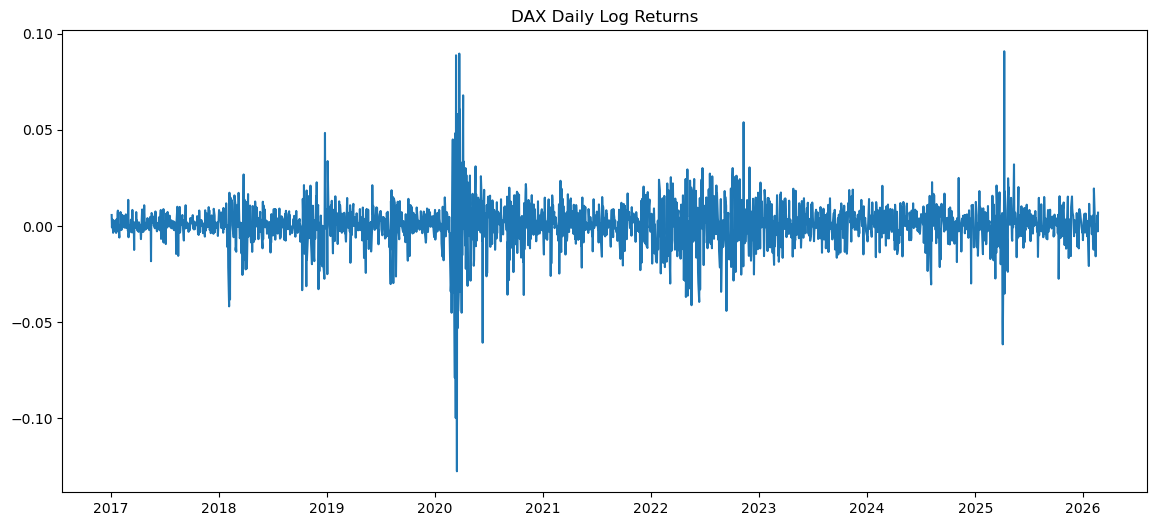

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(prices_sp500['Return'])
plt.title("DAX Daily Log Returns")
plt.show

In [ ]:
y = prices_sp500['Return']
X = prices_sp500[['Return']].shift(1)
lags = [1,2,5]
for lag in lags:
    X[f"Return_lag{lag}"] = X["Return"].shift(lag)

X = X.dropna()
print(X.head())
print(y.head())

              Return  Return_lag1  Return_lag2  Return_lag5
date                                                       
2017-01-12  0.002826     0.000000    -0.003555     0.005706
2017-01-13 -0.002147     0.002826     0.000000    -0.000771
2017-01-17  0.001848    -0.002147     0.002826     0.003511
2017-01-18 -0.002972     0.001848    -0.002147    -0.003555
2017-01-19  0.001762    -0.002972     0.001848     0.000000
date
2017-01-04    0.005706
2017-01-05   -0.000771
2017-01-06    0.003511
2017-01-09   -0.003555
2017-01-10    0.000000
Name: Return, dtype: float64


In [ ]:
#Adding Volatility Feature
#Shift by 1, so Return at t is not included in the Vol calculation at Time t
prices_sp500['Vol_30'] = prices_sp500['Return'].rolling(5).std().shift(1)
prices_sp500 = prices_sp500.dropna()

#Add Volatility to Training Data
X['Vol_30'] = prices_sp500['Vol_30']
X = X.dropna()
y = y.reindex(X.index)

X.head()


,Return,Return_lag1,Return_lag2,Return_lag5,Vol_30
date,,,,,
2017-01-12,0.002826,0.000000,-0.003555,0.005706,0.002861
2017-01-13,-0.002147,0.002826,0.000000,-0.000771,0.003061
2017-01-17,0.001848,-0.002147,0.002826,0.003511,0.002666
2017-01-18,-0.002972,0.001848,-0.002147,-0.003555,0.002490
2017-01-19,0.001762,-0.002972,0.001848,0.000000,0.002627


In [ ]:
from ngboost import NGBoost
from ngboost.distns import T
from ngboost.scores import LogScore
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler


In [ ]:
print(X.shape)
print(y.shape)


print(y.isna().sum())

(2289, 5)
(2289,)
0


In [ ]:
def run_expanding_backtest_ngboost(X, y, start_test_idx, var_levels, es_mc_samples):
    model = NGBoost(
        Dist=T,
        Score=LogScore,
        Base=DecisionTreeRegressor(max_depth=2, min_samples_leaf=50),
        learning_rate=0.005,
        n_estimators=400,
        natural_gradient=False,
        verbose=True,
    )
    rows = []
    
    X_vals = X.values
    y_vals = y.values
    idx = X.index
    n = len(X_vals)
    
    for t in range(start_test_idx, n):
        # Expanding window: train on everything up to t-1
        window = 252   
        start = max(0, t - window)
        X_train = X.iloc[start:t].values
        y_train = y.iloc[start:t].values    
        
        X_test = X_vals[t:t+1]  # ngboost needs 2d array - t:t+1
        y_test = float(y_vals[t])
        
        # Standardize X to improve numerical stability
        scaler_X = StandardScaler()
        X_train_std = scaler_X.fit_transform(X_train)
        X_test_std = scaler_X.transform(X_test)
        
        
        # Standardize y to stabilize StudentT fitting
        scaler_y = StandardScaler()
        y_train_std = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()
        
        model.fit(X_train_std, y_train_std)
        dist = model.pred_dist(X_test_std)
                
        out = {"Date": idx[t], "y_real": y_test}
        
        for a in var_levels:
            # Left tail probability
            q = 1 - a
            var_z = float(np.asarray(dist.ppf(q)).reshape(-1)[0])
            
            samples_z = dist.sample(es_mc_samples).reshape(-1)
            es_z = np.asarray(np.mean(samples_z[samples_z <= var_z]))
            
            var_val = float(scaler_y.inverse_transform([[var_z]])[0, 0])
            es_val  = float(scaler_y.inverse_transform([[es_z]])[0, 0])
            
            out[f"VaR_{int(a*100)}"] = var_val
            out[f"ES_{int(a*100)}"] = es_val
            
        rows.append(out)
    
    return pd.DataFrame(rows).set_index("Date")

In [ ]:
start_test_idx = 252 * 3

res = run_expanding_backtest_ngboost(
    X,
    y,
    start_test_idx=start_test_idx,
    var_levels=[0.95, 0.99],
    es_mc_samples=3000
)

[iter 0] loss=1.3712 val_loss=0.0000 scale=1.0000 norm=1.4827
[iter 100] loss=1.3104 val_loss=0.0000 scale=1.0000 norm=1.4680
[iter 200] loss=1.2717 val_loss=0.0000 scale=1.0000 norm=1.4916
[iter 300] loss=1.2408 val_loss=0.0000 scale=1.0000 norm=1.5229
[iter 0] loss=1.3687 val_loss=0.0000 scale=1.0000 norm=1.4871
[iter 100] loss=1.3078 val_loss=0.0000 scale=1.0000 norm=1.4723
[iter 200] loss=1.2681 val_loss=0.0000 scale=1.0000 norm=1.4960
[iter 300] loss=1.2364 val_loss=0.0000 scale=1.0000 norm=1.5276
[iter 0] loss=1.3706 val_loss=0.0000 scale=1.0000 norm=1.4834
[iter 100] loss=1.3105 val_loss=0.0000 scale=1.0000 norm=1.4693
[iter 200] loss=1.2709 val_loss=0.0000 scale=1.0000 norm=1.4932
[iter 300] loss=1.2397 val_loss=0.0000 scale=1.0000 norm=1.5246
[iter 0] loss=1.3693 val_loss=0.0000 scale=1.0000 norm=1.4860
[iter 100] loss=1.3097 val_loss=0.0000 scale=1.0000 norm=1.4727
[iter 200] loss=1.2691 val_loss=0.0000 scale=1.0000 norm=1.4946
[iter 300] loss=1.2380 val_loss=0.0000 scale=1.0

In [ ]:
res.to_csv("../data/processed/baseline_results.csv")
res.head()

,y_real,VaR_95,ES_95,VaR_99,ES_99
Date,,,,,
2020-01-15,0.001868,-0.007401,-0.011700,-0.014591,-0.018778
2020-01-16,0.008332,-0.005181,-0.009838,-0.011060,-0.016070
2020-01-17,0.003855,-0.005525,-0.008805,-0.010872,-0.015118
2020-01-21,-0.002656,-0.007759,-0.011760,-0.013743,-0.021628
2020-01-22,0.000289,-0.008031,-0.014173,-0.015928,-0.021535


In [ ]:
viol_99 = (res["y_real"] < res["VaR_99"]).mean()
print("Observed violation rate 99%:", viol_99)

Observed violation rate 99%: 0.014350945857795172


In [ ]:
res["violation_95"] = (res["y_real"] < res["VaR_95"]).astype(int)
res["violation_99"] = (res["y_real"] < res["VaR_99"]).astype(int)

violation_rate_95 = res["violation_95"].mean()
violation_rate_99 = res["violation_99"].mean()

print("Violation rate 95:", violation_rate_95)
print("Violation rate 99:", violation_rate_99)

Violation rate 95: 0.07893020221787345
Violation rate 99: 0.014350945857795172


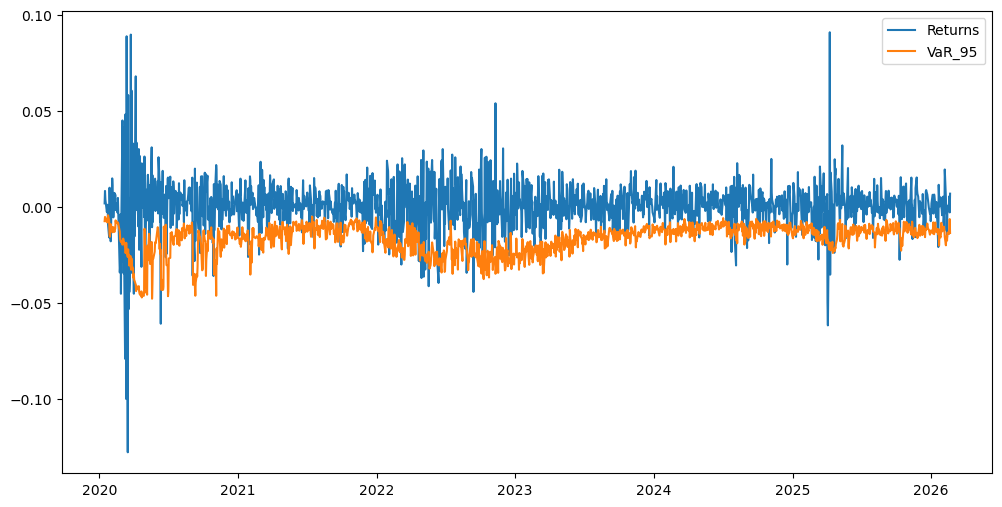

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(res.index, res["y_real"], label="Returns")
plt.plot(res.index, res["VaR_95"], label="VaR_95")
plt.legend()
plt.show()

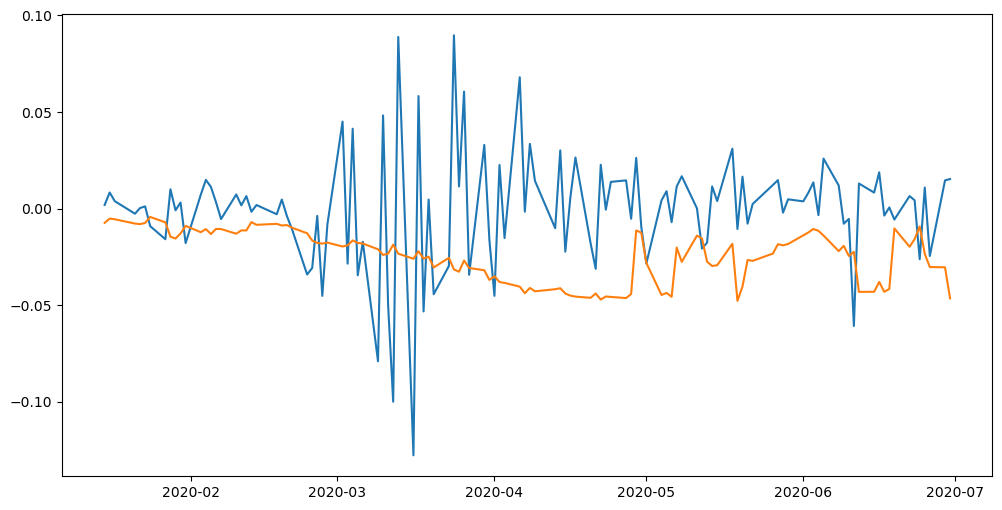

In [ ]:
res_2020 = res[(res.index >= "2020-01-01") & 
               (res.index <= "2020-06-30")]

plt.figure(figsize=(12,6))
plt.plot(res_2020.index, res_2020["y_real"])
plt.plot(res_2020.index, res_2020["VaR_95"])

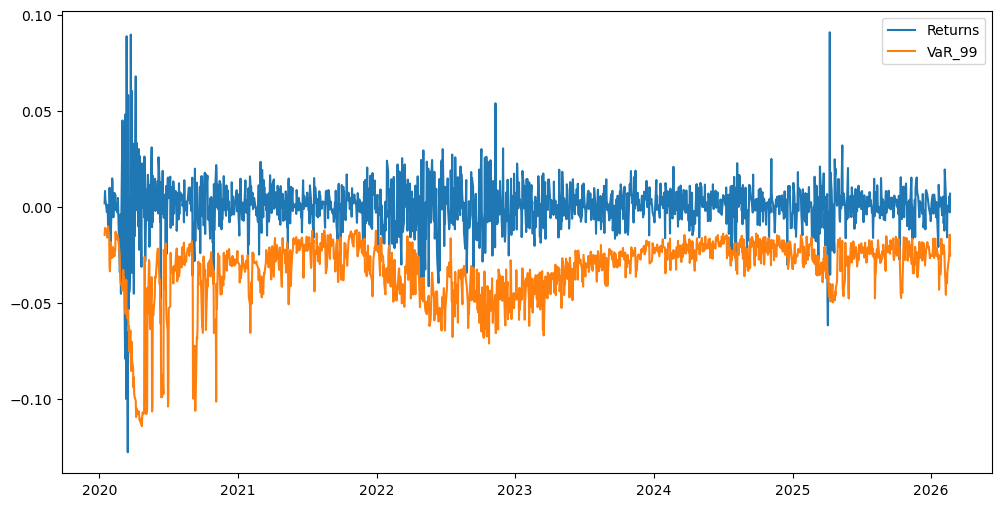

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(res.index, res["y_real"], label="Returns")
plt.plot(res.index, res["VaR_99"], label="VaR_99")
plt.legend()
plt.show()


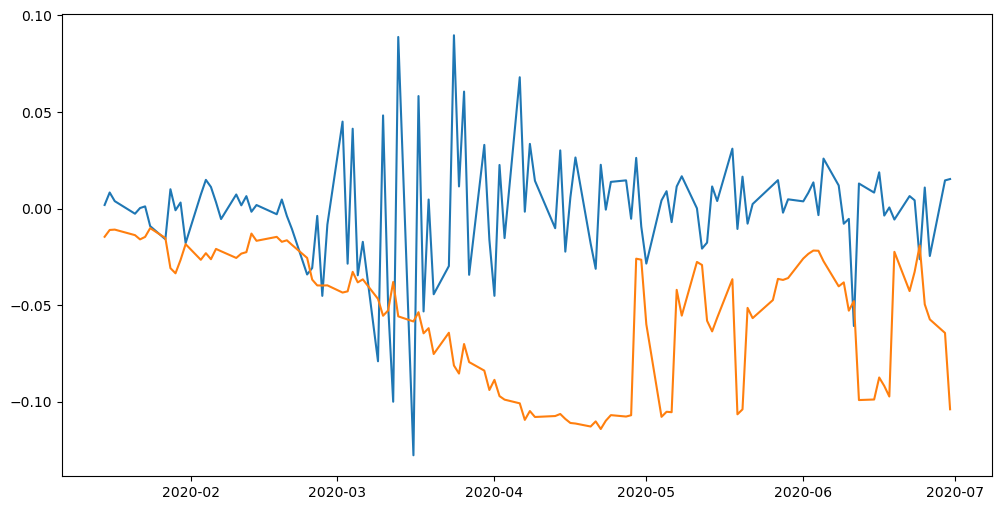

In [ ]:
res_2020 = res[(res.index >= "2020-01-01") & 
               (res.index <= "2020-06-30")]

plt.figure(figsize=(12,6))
plt.plot(res_2020.index, res_2020["y_real"])
plt.plot(res_2020.index, res_2020['VaR_99'])